# Regresión logística con Red Neuronal

**Integrantes**:
- Angélica Corrales Quevedo
- Santiago Trochez Velasco

En este notebook se realizará la implementación de una **Red Neuronal** usando regresión logística en un dataset de imágenes de tipo .h5, el cual contiene imágenes de personas felices y no felices.

## 1 - Paquetes ##

Primero vamos a importar los datasets necesarios para el proyecto, los cuales son los siguentes:
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
#from lr_utils import load_dataset

%matplotlib inline

Luego, **definimos una función** que nos permita cargar los datos de entrenamiento y prueba del dataset de personas felices desde Google Drive.

In [34]:
def load_dataset():
    train_dataset = h5py.File('/content/drive/MyDrive/IA II/lab_1/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/MyDrive/IA II/lab_1/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


## 2 - Carga del dataset y revisión de datos##

Para empezar, otorgamos permisos a Google Drive para poder obtener el dataset.

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Y luego, cargamos el dataset en variables de entrenamiento y prueba.

In [36]:
# Loading the data (happy/non-happy)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Después de cargar los datos, se procede a verificar la información que contiene el dataset, mostrando una imagen que contiene y su valor de clasificación **(si la persona está feliz o no)**

y = 1, they're 'happy' picture.


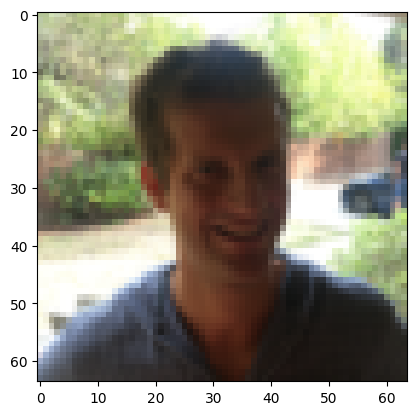

In [74]:
# Example of a picture
index = 9
plt.imshow(train_set_x_orig[index])

print ("y = " + str(train_set_y[0, index]) + ", they're '" + str("happy" if (classes[np.squeeze(train_set_y[:, index])]) else "unhappy") +  "' picture.")

Después, **analizaremos las dimensiones de cada variable y la estructa de las imágenes que componen la base de datos**, como su tamaño o cantidad de pixeles.

In [38]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test =  test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 600
Number of testing examples: m_test = 150
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (600, 64, 64, 3)
train_set_y shape: (1, 600)
test_set_x shape: (150, 64, 64, 3)
test_set_y shape: (1, 150)


Por conveniencia, tendremos que **re estructurar los 3 vectores que conforman cada imagen**, para ahora tener un solo vector con los valores RGB correspondientes y de esta forma poder realizar operaciones de forma rápida y efectiva.

In [39]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0])
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 600)
train_set_y shape: (1, 600)
test_set_x_flatten shape: (12288, 150)
test_set_y shape: (1, 150)
sanity check after reshaping: [178 191 206 242  48]


Para normalizar los vectores **aplanados** que ahora tenemos, tanto para entrenamiento como para prueba, **necesitamos dividir cada dataset por los valores de distribución del RGB**, el cual es **255**.

In [40]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 4 - Construir partes del algoritmo ##

Ahora, vamos a tener que construir cada parte matemática que compone al algoritmo, esto, para al final agrupar en una misma función, todas las funciones necesarias para el cálculo.

Primero, vamos a crear la función **sigmoide**, la cual es:
 $sigmoid( w^T x + b)$

In [41]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###

    return s

### 4.2 - Inicialización de parámetros

Ahora, inicializaremos dos parámetros, tanto **w** como **b** como vectores con ceros de tamaño **dim**.

In [42]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

### 4.3 - Propagación hacia adelante y hacia atrás

Para realizar la propagación, vamos a necesitar estas dos fórmulas:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

Luego, vamos a poder retornar los **costos** de la regresión logística realizada y los **gradientes** de pérdida tanto para **w** como para **b**.

In [43]:
# GRADED FUNCTION: propagate
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if unhappy, 1 if happy) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X) + b)              # compute activation
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m  # compute cost
    ### END CODE HERE ###

    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost

### 4.4 - Optimización

Para la **optimización** del algoritmo **gradient decent**, vamos a necesitar:

- Inicializar variables
- Calcular el costo y el gradiente por cada iteración.

Luego, podremos realizar la optimización del algoritmo y obtener los costos a partir de un **número de iteraciones** y un **learning rate** arbitrarios

In [44]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if unhappy, 1 if happy), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs = []

    for i in range(num_iterations):


        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ###
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)
        ### END CODE HERE ###

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

Ahora, tenemos que definir una función que utilice el algoritmo y nos ayude a **predecir** lo que buscamos. Esto, lo haremos a partir de la siguiente fórmula:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

Con esto, podemos **predecir** a partir de un valor específico. Si tenemos` => 0.5 `el resultado será una **persona feliz**. Si tenemos un valor` <= 0.5` el resultado será una **persona no feliz**.

In [45]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of happy being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T,X) + b)           # Dimentions = (1, m)
    ### END CODE HERE ###

    #### WORKING SOLUTION 1: USING IF ELSE ####
    #for i in range(A.shape[1]):
        ## Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        #if (A[0,i] >= 0.5):
        #    Y_prediction[0, i] = 1
        #else:
        #    Y_prediction[0, i] = 0
        ### END CODE HERE ###

    #### WORKING SOLUTION 2: ONE LINE ####
    #for i in range(A.shape[1]):
        ## Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        #Y_prediction[0, i] = 1 if A[0,i] >=0.5 else 0
        ### END CODE HERE ###

    #### WORKING SOLUTION 3: VECTORISED IMPLEMENTATION ####
    Y_prediction = (A >= 0.5) * 1.0

    assert(Y_prediction.shape == (1, m))

    return Y_prediction

## 5 - Integrar las funciones al modelo ##

Después de haber desarrollado todas las funciones anteriores que componen el modelo, las integraremos a una función llamada **model**

La función tendrá los siguientes parámetros de entrada:

    - Y_prediction_test para las predicciones en el conjunto de prueba
    - Y_prediction_train para las predicciones en el conjunto de entrenamiento
    - w, costs, grads para las salidas optimizadas

In [ ]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###

    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

#### Elección del learning rate ####

Para que Gradient Descent funcione, debemos elegir sabiamente el learning rate. El learning rate $\alpha$ determina la rapidez con la que actualizamos los parámetros. Si el learning rate es demasiado grande, podemos "sobrepasar" el valor óptimo. De manera similar, si es demasiado pequeño necesitaremos demasiadas iteraciones para converger a los mejores valores. Por eso es crucial utilizar una tasa de aprendizaje bien ajustada.


Ahora, probaremos varios valores de **learning rate** para encontrar un valor óptimo para nuestro modelo.

learning rate is: 0.001
train accuracy: 67.5 %
test accuracy: 43.99999999999999 %

-------------------------------------------------------

learning rate is: 0.0015
train accuracy: 69.66666666666666 %
test accuracy: 46.666666666666664 %

-------------------------------------------------------

learning rate is: 0.0019
train accuracy: 71.16666666666667 %
test accuracy: 47.333333333333336 %

-------------------------------------------------------

learning rate is: 0.0018
train accuracy: 71.0 %
test accuracy: 46.666666666666664 %

-------------------------------------------------------



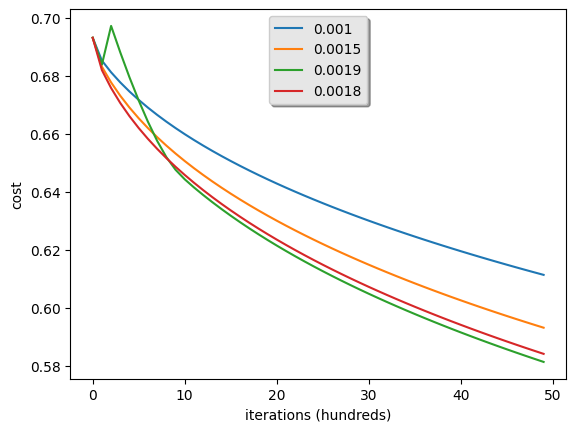

In [ ]:
learning_rates = [0.001, 0.0015, 0.0019, 0.0018]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 5000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()


Luego de obtener los resultados, nos dimos cuenta que los valores más óptimos se encontraban entre **0.0018** y **0.0019**, así que seguimos probando otras opciones cercanas a estos valores para encontrar un valor más óptimo para el modelo.

learning rate is: 0.00186
train accuracy: 71.16666666666667 %
test accuracy: 47.333333333333336 %

-------------------------------------------------------

learning rate is: 0.00184
train accuracy: 71.16666666666667 %
test accuracy: 48.0 %

-------------------------------------------------------

learning rate is: 0.00182
train accuracy: 71.16666666666667 %
test accuracy: 48.0 %

-------------------------------------------------------

learning rate is: 0.00185
train accuracy: 71.16666666666667 %
test accuracy: 48.0 %

-------------------------------------------------------



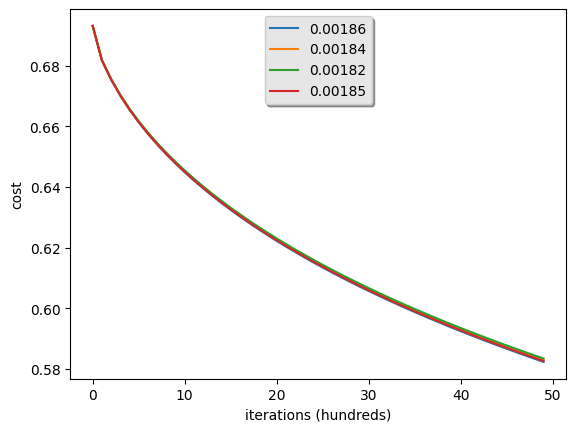

In [ ]:
learning_rates = [0.00186, 0.00184, 0.00182, 0.00185]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 5000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Anotaciones**:
- Nos dimos cuenta que presentamos **overfitting**, ya que nuestra precisión de entrenamiento fue mucho mayor que la precisión de prueba para cada uno de los valores.
- La precisión obtenida con en el rango de valores entre **0.00182** y **0.00185** son aproximadamente iguales.
- Teniendo en cuenta lo anterior, el valor seleccionado fue de **0.00184**
- Al momento de incrementar el número de iteraciones más allá de **5000**, no mejoraban los costos.


In [46]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 5000, learning_rate = 0.00184, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.681836
Cost after iteration 200: 0.675558
Cost after iteration 300: 0.670292
Cost after iteration 400: 0.665683
Cost after iteration 500: 0.661550
Cost after iteration 600: 0.657783
Cost after iteration 700: 0.654309
Cost after iteration 800: 0.651076
Cost after iteration 900: 0.648046
Cost after iteration 1000: 0.645189
Cost after iteration 1100: 0.642482
Cost after iteration 1200: 0.639906
Cost after iteration 1300: 0.637447
Cost after iteration 1400: 0.635091
Cost after iteration 1500: 0.632828
Cost after iteration 1600: 0.630650
Cost after iteration 1700: 0.628550
Cost after iteration 1800: 0.626520
Cost after iteration 1900: 0.624556
Cost after iteration 2000: 0.622652
Cost after iteration 2100: 0.620805
Cost after iteration 2200: 0.619010
Cost after iteration 2300: 0.617264
Cost after iteration 2400: 0.615565
Cost after iteration 2500: 0.613909
Cost after iteration 2600: 0.612293
Cost after iteration 2700: 0.610717
Cost

Ahora, se grafican los costos del **learning rate** elegido en función de cantidad de iteraciones.

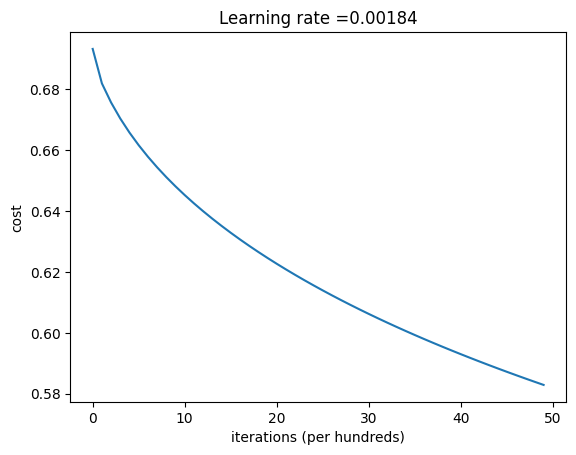

In [47]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretación**:
A partir de la gráfica anterior, podemos ver que entre más iteraciones, menor costo vamos a tener con un **learning rate de 0.00184**

## 6 - Prueba del modelo con una imagen ##

Ahora, vamos a probar la efectividad de nuestro modelo con una imagen de un hombre no feliz y obteniendo su predicción.

[[0.]]
y = 0.0, your algorithm predicts a "unhappy" picture.


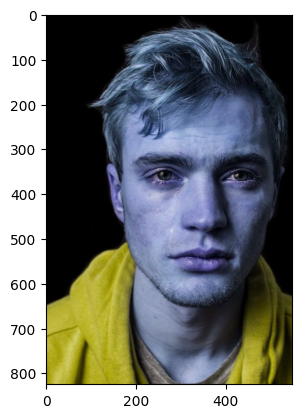

In [68]:
import cv2

# read image
img = cv2.imread('/content/drive/MyDrive/IA II/lab_1/llorando.jpg', cv2.IMREAD_UNCHANGED)

# get dimensions of image
dimensions = img
# We preprocess the image to fit your algorithm.
resizedImage = cv2.resize(img, (64, 64))

my_image = resizedImage.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)
print(my_predicted_image)
plt.imshow(img)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + str("happy" if (classes[int (np.squeeze(my_predicted_image))]) else "unhappy") +  "\" picture.")